In [2]:
import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import librosa

from scipy import stats, spatial, ndimage
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.Gaze_aversion_prior.Evan_model import Aversion111Prior
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_simple, Responsive_planner_no_heuristics, Responsive_planner_no_Gaze_deploy
import pickle
import math
import re

from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D, runEuro
from scipy.interpolate import interp1d
from Geometry_Util import directions_from_rotation_angles


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
%load_ext autoreload
%autoreload 1

%aimport prototypes.InputDataStructures
%aimport Speech_Data_util
%aimport Signal_processing_utils
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck
%aimport prototypes.Gaze_aversion_prior.Evan_model



# Input Block

### You need to make the temp folder yourself before running these

In [4]:
# inputs
# input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
input_folder = "F:/MASC/shot_processed_dataset/"
input_file = "Allison Ungar Self Tape_0"
model_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/prototypes/Gaze_aversion_prior/sentence_word_audio_velocity_model"
whisper_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/models"
temp_folder = "F:/MASC/JALI_gaze/Animations/Allison_Ungar" 
speaker_id = 0
turn_taking_threshold = 2
fps = 25
np.random.seed(speaker_id)

## Get all the file paths

In [5]:
input_file_no_space = input_file.replace(" ", "_")
gaze_animation_output_location = os.path.join(*[temp_folder, "outputs"])
try:
    os.mkdir(os.path.join(*[temp_folder, "outputs"]))   
except:
    print("folder already exist")   
try:
    os.mkdir(os.path.join(*[temp_folder, "annotated_scene"]))   
except:
    print("folder already exist")    
# input_file_no_space = "'" + input_file_no_space + "'"
praatoutput_1_path = os.path.join(temp_folder, input_file_no_space+"_{}_PraatOutput.txt".format(speaker_id))
head_direction_json_path = os.path.join(*[input_folder, "head", input_file+".pkl"])
gaze_direction_json_path = os.path.join(*[input_folder, "gaze", input_file+".pkl"])
audio_path = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)])
text_file_path = os.path.join(*[temp_folder, input_file_no_space+"_{}.txt".format(speaker_id)])
transcript_file_path = os.path.join(*[temp_folder, input_file+"_transcript.json".format(speaker_id)])
tagged_text_file_path = os.path.join(*[temp_folder, input_file_no_space+"_{}_tagged.txt".format(speaker_id)])

# output paths
output_neural_location = os.path.join(*[temp_folder, "outputs", input_file+"_neural.pkl"])
output_turn_taking_location = os.path.join(*[temp_folder, "outputs", input_file+"_turn_taking.pkl"])
output_gaze_deploy_location = os.path.join(*[temp_folder, "outputs", input_file+"_gaze_deploy.pkl"])
output_static_salience_location = os.path.join(*[temp_folder, "outputs", input_file+"_static_salience_map.pkl"])
output_stare_location = os.path.join(*[temp_folder, "outputs", input_file+"_stare.pkl"])
# other important input data (such as scene )
annotation_data_path = os.path.join(*[temp_folder, "annotated_scene", input_file+"_points.pkl"])
scene_data_path = os.path.join(*[temp_folder, "annotated_scene", input_file+"_scene.json"])
basic_scene_data_path = "./data/look_at_points/simplest_scene2_less_items.json"
print("gaze data is here:\n"+gaze_direction_json_path)
print("please store the output at:\n"+annotation_data_path)

folder already exist
folder already exist
gaze data is here:
F:/MASC/shot_processed_dataset/gaze\Allison Ungar Self Tape_0.pkl
please store the output at:
F:/MASC/JALI_gaze/Animations/Allison_Ungar\annotated_scene\Allison Ungar Self Tape_0_points.pkl


# Run cluster_picker.py to generate a scene, then run the following to generate a scene file

In [6]:
annotation = pkl.load(open(annotation_data_path, "rb"))
annotation = np.array(annotation)
annotation_positions = directions_from_rotation_angles(annotation[:, :2], 200)
scene_json = json.load(open(basic_scene_data_path))
scene = AgentInfo(basic_scene_data_path)
for i in range(0, annotation_positions.shape[0]):
    annotation_positions[i] = scene.transform_local_to_world(annotation_positions[i])
world_pos_center = np.array(scene_json["self_pos"]["calibration_dir_world"])
# generate names of these objects:
object_names = []
speaker_count = 0
object_count = 0
# also try to find out where the speaker is
speaker_pos = None
for i in range(0, annotation.shape[0]):
    if annotation[i, 2] == -1:
        object_names.append("object_{}".format(object_count))
        object_count = object_count + 1
    elif annotation[i, 2] == 1:
        object_names.append("partner_{}".format(speaker_count))
        speaker_count = speaker_count + 1
        speaker_pos = annotation_positions[i]
object_interestingness = {}
object_type = {}
object_pos = {}
correction_vector = world_pos_center - speaker_pos
# slightly modify the probability so they are not too low
speaker_interestingness = 0
for i in range(0, annotation.shape[0]):
    if annotation[i, 2] == 1:
        speaker_interestingness = annotation[i, 3]
for i in range(0, annotation.shape[0]):
    if annotation[i, 2] == -1:
        object_interestingness[object_names[i]] = annotation[i, 3] / speaker_interestingness
        object_type[object_names[i]] = 2
    elif annotation[i, 2] == 1:
        object_interestingness[object_names[i]] = 1.0
        object_type[object_names[i]] = 5
    object_pos[object_names[i]] = annotation_positions[i].tolist()
output = {}
output["object_interestingness"] = object_interestingness
output["object_pos"] = object_pos
output["object_type"] = object_type
output["self_pos"] = scene_json["self_pos"]
json.dump(output, open(scene_data_path, "w"))
print(scene_data_path)

F:/MASC/JALI_gaze/Animations/Allison_Ungar\annotated_scene\Allison Ungar Self Tape_0_scene.json


# Obtain Tag timing

In [7]:
import string
# Load the transcript list from the JSON file
with open(transcript_file_path, 'r') as f:
    if speaker_id == 0:
        transcript_list = json.load(f)["self"]
    else:
        transcript_list = json.load(f)["other"]

# Load the transcript text file
with open(tagged_text_file_path, 'r') as f:
    transcript = f.read()

word_list = [word["text"] for word in transcript_list]
translator = str.maketrans('', '', string.punctuation.replace('<', '').replace('>', '').replace('-', '').replace('_', '').replace("'", ''))
# Remove all punctuation except < and > from the input string using the translation table
word_list = [word.translate(translator) for word in word_list]
transcript = transcript.translate(translator)
transcript = transcript.split(" ")
transcript = [s for s in transcript if s != ""]
i = 0
j = 0
tag_durations = {}
active_tag = None
active_tag_interval = []
while i < len(transcript):
    if transcript[i] == word_list[j]:
        i += 1
        j += 1
    else:
        if active_tag is None:
            active_tag = transcript[i][1:-1]
            active_tag_interval = [j]
        else:
            active_tag = transcript[i][1:-1]
            active_tag_interval.append(j+1)
            active_tag_interval[0] = transcript_list[active_tag_interval[0]]["start"]
            active_tag_interval[1] = transcript_list[active_tag_interval[1]]["start"]
            try:
                tag_durations[active_tag].append(active_tag_interval.copy())
            except:
                tag_durations[active_tag] = [active_tag_interval.copy()]
            active_tag_interval = []
            active_tag = None
        i += 2
        j += 1

In [8]:
sementic_script_1 = Sentence_word_phone_parser(praatoutput_1_path, praatoutput_1_path)
sementic_script_1.get_turns(turn_taking_threshold)
# agentScene1 = AgentInfo(scene_data_path, wonder=False)
agentScene1 = AgentInfo(scene_data_path, wonder=True)

# Use the power of deep learning to generate all the transcripts and gaze aversion predictions!

In [9]:
class Neural_input_Saliency(Base_Static_Saliency_List):
    def __init__(self, scene_info: AgentInfo, ts, dt=1/24):
        self.scene_info: AgentInfo = scene_info
        self._number_of_objects = scene_info.get_all_positions().shape[0]
        self._dt = dt # 100 hz
        self._numb_of_frames = ts.shape[0] # total number of frames
        self.evaluated = False
        self.map = np.zeros((int(self._numb_of_frames), self._number_of_objects))
        self.map_interp = None
    def get_object_positions(self):
        return self.scene_info.get_all_positions()
    
    def evaluate_all(self):
        if self.evaluated:
            return self.map
        else:
            self.compute_salience()
            x = np.arange(0, self._numb_of_frames) * self._dt
            self.map_interp = interp1d(x, self.map, axis=0, fill_value="extrapolate")
            self.evaluated = True
            return self.map
    def evaluate(self, t):
        if self.evaluated:
            return self.map_interp(t)
        else:
            self.compute_salience()
            x = np.arange(0, self._numb_of_frames) * self._dt
            self.map_interp = interp1d(x, self.map, axis=0, fill_value="extrapolate")
            self.evaluated = True
            return self.map_interp(t)
    def compute_salience(self, aversion_prob_time, aversion_prob_val, interval=True):
        # continue setting salience for all objects
        for j in range(0, self._numb_of_frames):
            for i in range(0, self._number_of_objects):
                if i < self.scene_info.get_object_positions(coordinate_space="global").shape[0]:
                    self.map[j, i] = self.scene_info.object_interest[i]
                elif i == self.scene_info.get_object_positions(coordinate_space="global").shape[0]:
                    self.map[j, i] = 1 - interpolate1D(aversion_prob_time, aversion_prob_val, float(j) * self._dt)                
                else:
                    if interpolate1D(aversion_prob_time, aversion_prob_val, float(j) * self._dt) < 0.3:
                        self.map[j, i] = 0
                    else:
                        self.map[j, i] = 0.5

# aversion_saliency = TurnTakingDrivenSaliency(scene, audio, None, dt=0.02)
# aversion_saliency.compute_salience(ts, turn_taking_salience_list)


(2321,)


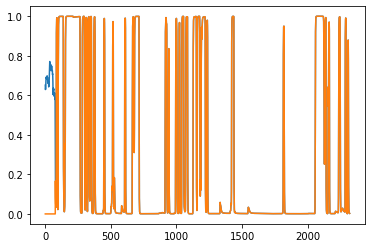

In [10]:
model = Aversion111Prior(model_location, whisper_location)
aversion_probabilities = model.predict(temp_folder, input_folder, input_file, 0)
ts = np.arange(0, aversion_probabilities.shape[0]) / fps
# 1 is direct gaze, 0 is aversion, here I want aversion probability
aversion_probability = runEuro(ts, aversion_probabilities)[:, 0]
plt.plot(aversion_probability)
# since the model doesn't give prediction until later in the audio. 
# I will omit the prediction until the mode is fairly certain
print(aversion_probability.shape)
for i in range(0, aversion_probability.shape[0]):
    if np.abs(aversion_probability[i] - 0.5) <= 0.3:
        aversion_probability[i] = 0
    else:
        break
plt.plot(aversion_probability, label="")
aversion_probability = np.where(aversion_probability > 0.5, 1, 0)
# plt.plot(aversion_probability)

## Apply the Stare Tag to the signal 

In [13]:
try:
    stare_intervals = tag_durations["stare"]
    stare_intervals_index_sets = []
    for i in range(0, len(stare_intervals)):
        index_set = []
        for t in range(ts.shape[0]):
            if ts[t] >= stare_intervals[i][0] and len(index_set) == 0:
                index_set.append(t)
            if ts[t] >= stare_intervals[i][1]:
                index_set.append(t)
                break
        stare_intervals_index_sets.append(index_set)

    for i in range(len(stare_intervals_index_sets)):
        aversion_probability[stare_intervals_index_sets[i][0]:stare_intervals_index_sets[i][1]] = 0
except:
    pass

In [14]:
np.random.seed(0)
aversion_saliency = Neural_input_Saliency(agentScene1, ts, 1.0/fps)
aversion_saliency.compute_salience(ts, aversion_probability)

## Apply Directional Tag

In [15]:
look_up_intervals = []
try:
    look_up_intervals = tag_durations["up"]
except:
    pass
look_up_intervals_index_sets = []
for i in range(0, len(look_up_intervals)):
    index_set = []
    for t in range(ts.shape[0]):
        if ts[t] >= look_up_intervals[i][0] and len(index_set) == 0:
            index_set.append(t)
        if ts[t] >= look_up_intervals[i][1]:
            index_set.append(t)
            break
    look_up_intervals_index_sets.append(index_set)
objects_positions = aversion_saliency.get_object_positions()
above = np.where(objects_positions[:, 1] >= objects_positions[aversion_saliency.scene_info.get_object_positions().shape[0], 1]+5, 1, 0)
above[aversion_saliency.scene_info.get_object_positions(coordinate_space="global").shape[0]] = 1
for i in range(len(look_up_intervals_index_sets)):
    mask = np.tile(np.expand_dims(above, axis=0), [look_up_intervals_index_sets[i][1] - look_up_intervals_index_sets[i][0], 1])
    aversion_saliency.map[look_up_intervals_index_sets[i][0]:look_up_intervals_index_sets[i][1]] *= mask

## Compute Gaze Targets

In [53]:
planner = Responsive_planner_no_Gaze_deploy([aversion_saliency], scene, aversion_probability)
output_times, output_targets = planner.compute()

In [55]:
# =============================================================================================
# ========================== plan scan path based on the saliency maps ========================
# =============================================================================================
#get the output_targets_positions from the scene
output_target_positions = []
for i in output_targets:
    output_target_positions.append(scene.get_all_positions(coordinate_space="local", index=i))
internal_model = InternalModelCenterBias(scene)
# the good model
generator = SacccadeGenerator(output_times, output_target_positions, output_targets, internal_model, dt=1/fps)
# print(output_times, output_target_positions, output_targets)
ek, hk, micro_saccade = generator.compute()
conversational_neck = NeckCurve(audio_path)
jali_neck_output = conversational_neck.compute_curve()

blend_weight = []
for i in range(1, len(hk[0])-1):
    velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
    blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
# motion_generator = HeuristicGazeMotionGenerator(scene, sementic_script)
# ek, hk, micro_saccade = motion_generator.generate_neck_eye_curve(output_times, output_target_positions)
# output_location = "C:/Users/evan1/Documents/Gaze_project/data/look_at_points/prototype2p2.pkl"
# output_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"
# output_location = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"
out = {"eye_frames": ek,
        "head_frames": hk,
        "micro_saccade": micro_saccade,
        "other_neck": jali_neck_output,
        "envelope":[]}
        # "output_times": output_times, 
        # "output_targets": output_targets
pickle.dump(out, open(output_neural_location, 'wb'), protocol=2)
print(output_neural_location)

75 (75, 2)
3.4
0.08000000000000007
0.20000000000000018
0.31999999999999984
1.3600000000000012
0.08000000000000007
0.11999999999999922
0.5999999999999996
1.4400000000000013
0.08000000000000007
1.2799999999999798
0.0799999999999983
1.359999999999971
0.1599999999999966
0.08000000000005336
0.6799999999999979
0.6800000000000015
0.3200000000000003
0.35999999999999943
0.3200000000000003
0.4399999999999995
0.2400000000000002
0.4400000000000013
0.7199999999999989
0.3600000000000012
2.719999999999997
0.20000000000000284
2.4399999999999977
0.20000000000000284
3.479999999999997
0.240000000000002
2.120000000000001
0.4399999999999977
0.1999999999999993
1.4399999999999693
-0.03999999999996717


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
0.1 @ power(var14506 + -31.662545608024743, 2.0) + -0.03999999999996717 @ power(49.65483209184486 + -var14506, 2.0) + 1.0399999999999672 @ power(var14506 + -7.0161541313923586, 2.0)